## Accès à la base de données sur l'éclairage depuis une API et importation du DataFrame

A partir du site internet [data.gouv](https://www.data.gouv.fr/fr/datasets/emplacements-dimplantation-de-cameras-de-videoprotection-bo-ville-de-paris-du-01-02-2019/), nous mettons en place une API pour récuperer les données (en version beta lors de l'écriture du présent).
Nous récupérons l'ID du jeu de données (ici : 0f195145-1f5a-4762-9edc-40031ba4402f).

In [318]:
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from cartiflette import carti_download


#Création du point d'accès
api_root_videoprotection = "https://tabular-api.data.gouv.fr/api/resources/"
ID_datagouv = "0f195145-1f5a-4762-9edc-40031ba4402f"
url_api_videoprotection = api_root_videoprotection + ID_datagouv + "/data/"
print(url_api_videoprotection)

#Test API
try:
    response = requests.get(url_api_videoprotection)
    response.raise_for_status()
    wb = response.json()
except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête : {e}")
except ValueError:
    print("Erreur : Impossible de décoder le JSON.")

#Récupération des données sous format Json (plusieurs pages sont à parcourirs)

def recuperation_data(url_api):
    df = []  # Liste pour accumuler les données
    current_url = url_api

    while current_url:
        req = requests.get(current_url)
        wb = req.json()
        df.extend(wb['data'])
        current_url = wb["links"].get("next")
    return pd.DataFrame(df)

df_videoprotection = recuperation_data(url_api_videoprotection)

# Convertir les coordonnées en objets géométriques (de lon, lat à des points)
geometry = gpd.GeoSeries.from_xy(df_videoprotection.lon, df_videoprotection.lat)
df_videoprotection['geometry'] = geometry
gdf_videoprotection = gpd.GeoDataFrame(df_videoprotection, geometry='geometry')
gdf_videoprotection.set_crs('EPSG:4326', inplace=True)  # On identifie le CRS WGS 84



  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-mkqx4yh8
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-mkqx4yh8
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
https://tabular-api.data.gouv.fr/api/resources/0f195145-1f5a-4762-9edc-40031ba4402f/data/


,__id,Code postal,Numéro,Implantation,Précision de l’implantation,Date de mise en service,lon,lat,geometry
0,1,75001,1051,"Rue Saint-Denis, rue de Rivoli",croisement,08/07/16,2.347502,48.858750,POINT (2.3475 48.85875)
1,2,75001,1055,"Rue Montmartre, rue de Turbigo",croisement,10/03/17,2.346124,48.863243,POINT (2.34612 48.86324)
2,3,75001,1056,"Rue Montorgueil, rue de Turbigo",croisement,10/03/17,2.346291,48.863273,POINT (2.34629 48.86327)
3,4,75001,1057,"Quai François Mitterrand, rue de l'Amiral de C...",croisement,08/06/18,2.339848,48.858990,POINT (2.33985 48.85899)
4,5,75002,2006,"Boulevard des Capucines, rue Scribe",croisement,Début 2019,2.329943,48.870250,POINT (2.32994 48.87025)
...,...,...,...,...,...,...,...,...,...
702,703,75001,99000,"Quai François Mitterrand, Pont du Carrousel",croisement,41334,2.333352,48.860112,POINT (2.33335 48.86011)
703,704,75004,29297B,"Place de l'Hôtel de Ville, avenue Victoria",croisement,03/02/12,2.351083,48.856768,POINT (2.35108 48.85677)
704,705,75015,45963B,"Place Raoul Dautry, boulevard de Vaugirard, ru...",croisement,20/04/12,2.319936,48.841863,POINT (2.31994 48.84186)
705,706,75005,67726B,"Place du Puits de L'Ermite, rue de Quatrefages",croisement,21/12/11,2.354492,48.842396,POINT (2.35449 48.8424)


Une colonne indiquant les arrondissements avec le code INSEE_COG est également ajoutée pour harmoniser les données avec celles provenant d'autres sources.

In [319]:
# Fonction pour extraire et formater l'arrondissement
def extraire_arrondissement(code_postal):
    try:
        arrondissement = int(code_postal[-2:])  # Récupérer les deux derniers chiffres
        return f"751{arrondissement:02d}"
    except ValueError:
        return "Arrondissement inconnu"  # Gérer les cas où le code postal est invalide

# Ajouter la colonne 'INSEE_COG'
gdf_videoprotection['INSEE_COG'] = gdf_videoprotection['Code postal'].apply(extraire_arrondissement)
gdf_videoprotection.head(5)


,__id,Code postal,Numéro,Implantation,Précision de l’implantation,Date de mise en service,lon,lat,geometry,INSEE_COG
0,1,75001,1051,"Rue Saint-Denis, rue de Rivoli",croisement,08/07/16,2.347502,48.858750,POINT (2.3475 48.85875),75101
1,2,75001,1055,"Rue Montmartre, rue de Turbigo",croisement,10/03/17,2.346124,48.863243,POINT (2.34612 48.86324),75101
2,3,75001,1056,"Rue Montorgueil, rue de Turbigo",croisement,10/03/17,2.346291,48.863273,POINT (2.34629 48.86327),75101
3,4,75001,1057,"Quai François Mitterrand, rue de l'Amiral de C...",croisement,08/06/18,2.339848,48.858990,POINT (2.33985 48.85899),75101
4,5,75002,2006,"Boulevard des Capucines, rue Scribe",croisement,Début 2019,2.329943,48.870250,POINT (2.32994 48.87025),75102


## Statistique descriptive
### Analyse géographique
Nous projetons désormais les points sur une carte de Paris en utilisant un fond de carte par le biais de cartiflette.

   INSEE_DEP  INSEE_REG                        ID                       NOM  \
0         75         11  ARR_MUNI0000000009736045   Paris 3e Arrondissement   
1         75         11  ARR_MUNI0000000009736046   Paris 2e Arrondissement   
2         75         11  ARR_MUNI0000000009736545   Paris 4e Arrondissement   
3         75         11  ARR_MUNI0000000009736544   Paris 5e Arrondissement   
4         75         11  ARR_MUNI0000000009736543   Paris 6e Arrondissement   
5         75         11  ARR_MUNI0000000009736043   Paris 9e Arrondissement   
6         75         11  ARR_MUNI0000000009736042  Paris 10e Arrondissement   
7         75         11  ARR_MUNI0000000009736035  Paris 11e Arrondissement   
8         75         11  ARR_MUNI0000000009736531  Paris 13e Arrondissement   
9         75         11  ARR_MUNI0000000009736044   Paris 8e Arrondissement   
10        75         11  ARR_MUNI0000000009736541  Paris 14e Arrondissement   
11        75         11  ARR_MUNI0000000009736041  P

<Axes: title={'center': 'Arrondissements de Paris'}>

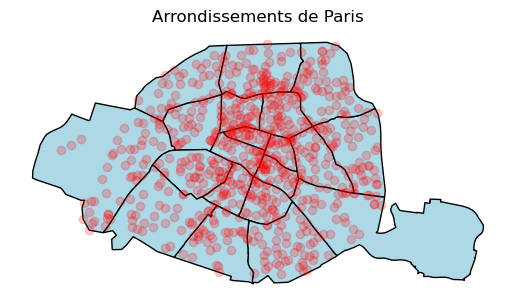

In [320]:
#Importation de la carte des arrondissement et création du fond de carte

arr_borders = carti_download(
    crs=4326,
    values=["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

print(arr_borders)


#création du fond de carte
base = arr_borders.plot(color="lightblue", edgecolor="black")
base.set_axis_off()
base.set_title("Arrondissements de Paris")


#Intégration de la localisation des caméras de surveillance
gdf_videoprotection.plot(ax=base, color = "red", alpha = 0.2)




On regarde la répartition des caméras de vidéoprotection par arrondissement en nombre puis en densité.

Nombre total de caméra de videoprotection : 707
  INSEE_COG  nombre                                           geometry
0     75118      57  POLYGON ((2.3703 48.90185, 2.36562 48.90176, 2...
1     75113      50  POLYGON ((2.3439 48.81577, 2.34445 48.81556, 2...
2     75116      47  POLYGON ((2.27995 48.87857, 2.27947 48.87853, ...
3     75119      46  POLYGON ((2.3769 48.87205, 2.37764 48.8723, 2....
4     75107      45  POLYGON ((2.31671 48.84686, 2.31954 48.84791, ...


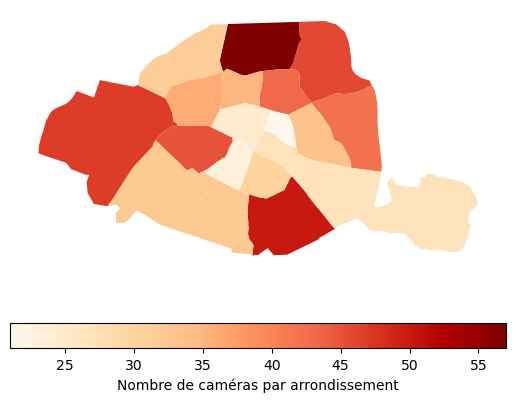

In [321]:


print(f"Nombre total de caméra de videoprotection : {gdf_videoprotection.shape[0]}")

couverture_videoprotection_par_arrondissement = gdf_videoprotection['INSEE_COG'].value_counts()

df_couverture_videoprotection_par_arrondissement = couverture_videoprotection_par_arrondissement.reset_index()
df_couverture_videoprotection_par_arrondissement.columns = ['INSEE_COG', 'nombre']

#Ajout des geometry aux arrondissements en récupérant les données de arr_borders

df_couverture_videoprotection_par_arrondissement = df_couverture_videoprotection_par_arrondissement.merge(arr_borders[['INSEE_COG', 'geometry']], on='INSEE_COG', how='left')
gdf_couverture_videoprotection_par_arrondissement = gpd.GeoDataFrame(df_couverture_videoprotection_par_arrondissement,geometry='geometry')
print(gdf_couverture_videoprotection_par_arrondissement.head(5))


carte_repartition_camera = gdf_couverture_videoprotection_par_arrondissement.plot(
    column = 'nombre',
    cmap='OrRd',
    legend=True,
    legend_kwds={"label": "Nombre de caméras par arrondissement", "orientation": "horizontal"},
)
carte_repartition_camera.set_axis_off()


EPSG:4326


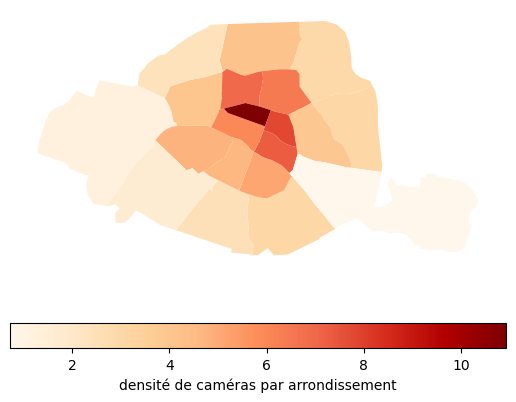

In [322]:
print(gdf_couverture_videoprotection_par_arrondissement.crs)
#Projection du système de coordonnées géographique (lat/lon, 4326) un système métrique permettant de garantir le calcule des surface EPSG:3395
gdf_couverture_videoprotection_par_arrondissement = gdf_couverture_videoprotection_par_arrondissement.to_crs(epsg=3395) 

# Calculer la surface et ajouter une colonne 'surface'
gdf_couverture_videoprotection_par_arrondissement['surface'] = gdf_couverture_videoprotection_par_arrondissement.geometry.area/ 1e6


#Calcul de la densité
gdf_couverture_videoprotection_par_arrondissement['densite_camera'] = (gdf_couverture_videoprotection_par_arrondissement['nombre'] / gdf_couverture_videoprotection_par_arrondissement['surface'])

carte_repartition_camera = gdf_couverture_videoprotection_par_arrondissement.plot(
    column = 'densite_camera',
    cmap='OrRd',
    legend=True,
    legend_kwds={"label": "densité de caméras par arrondissement", "orientation": "horizontal"},
)
carte_repartition_camera.set_axis_off()


Remarquons que nous retrouvons les résultats d'un modèle centre périphérie avec l'observation des densités de caméras de vidéoprotection au $\text{km}^2$.

### Analyse temporelle

Nous unifions le format de date de la base de donnée


In [323]:
def convert_date_format(date_str):
    # Cas 1 : Si la date commence par "Début", convertir en "01/01/yyyy"
    if isinstance(date_str, str) and date_str.startswith("Début"):
        year = date_str.split()[-1]  # Extraire l'année après 'Début'
        new_date_str = f"01/01/{year}"
        return pd.to_datetime(new_date_str, format='%d/%m/%Y', errors='raise')

    # Cas 2 : Si la date est sous forme de chaîne 'jj/mm/yy', convertir en datetime
    if isinstance(date_str, str) and len(date_str) == 8 and date_str[2] == '/' and date_str[5] == '/':
        return pd.to_datetime(date_str, format='%d/%m/%y', errors='raise')

    # Cas 3 : Si la date est une chaîne représentant un nombre (format Excel), la convertir en datetime
    if isinstance(date_str, str) and date_str.isdigit(): 
        num_date = float(date_str)  # Convertir la chaîne de caractères en nombre
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(num_date, unit='D')

    # Cas 4 : Si la date est déjà un nombre (format Excel), la convertir directement en datetime
    if isinstance(date_str, (int, float)): 
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(float(date_str), unit='D')

    # Si aucun format ne correspond
    return None

gdf_videoprotection['Date de mise en service'] = gdf_videoprotection['Date de mise en service'].apply(convert_date_format)



/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


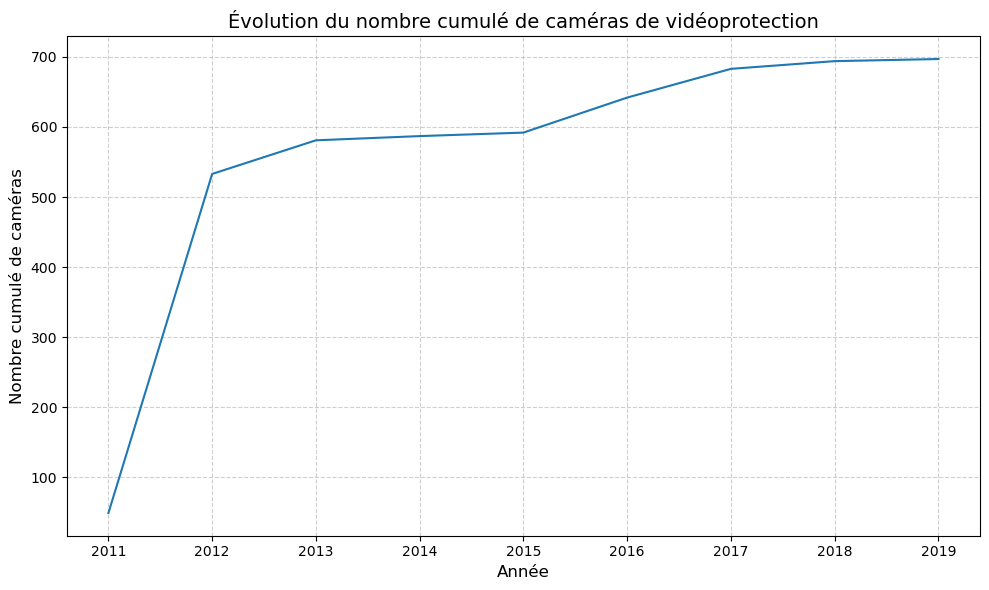

In [324]:
gdf_videoprotection = gdf_videoprotection.dropna(subset=['Date de mise en service'])

# Extraire l'année de mise en service et compter le nombre de caméras mises en service par année
gdf_videoprotection['Année'] = gdf_videoprotection['Date de mise en service'].dt.year
cameras_par_annee = gdf_videoprotection.groupby('Année').size().cumsum()

# Tracer l'évolution du nombre cumulé de caméras
plt.figure(figsize=(10, 6))
plt.plot(cameras_par_annee.index, cameras_par_annee.values)

# Personnalisation du graphique
plt.title("Évolution du nombre cumulé de caméras de vidéoprotection", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre cumulé de caméras", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Afficher le graphique
plt.show()

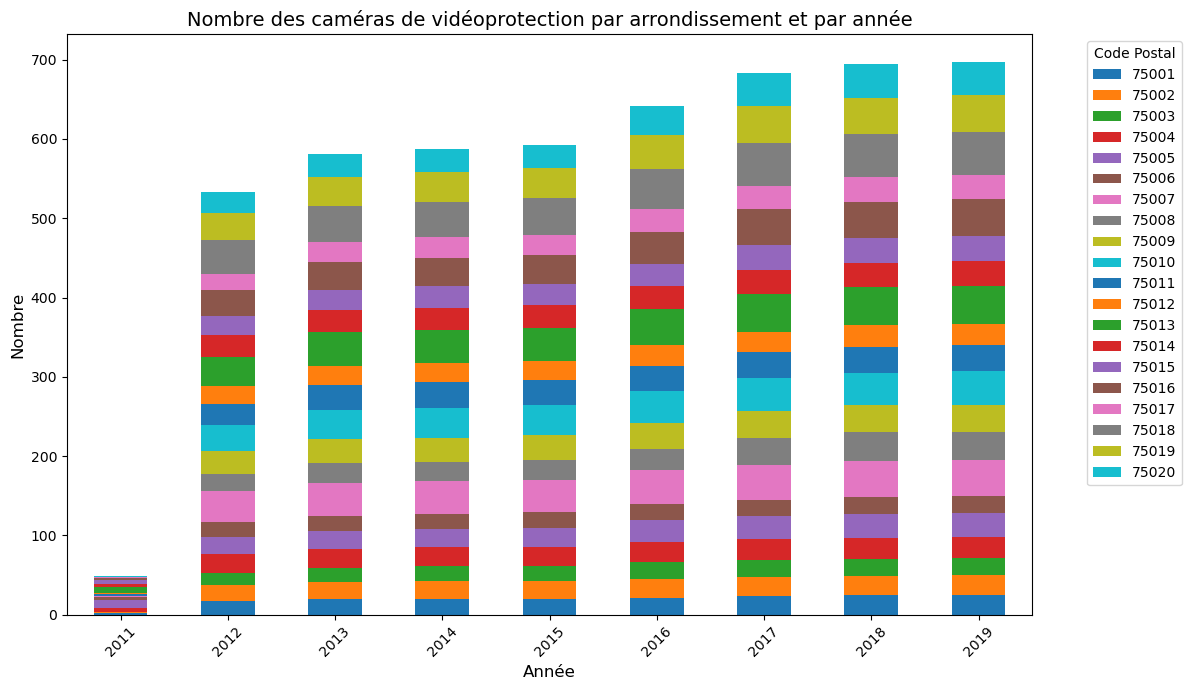

In [326]:
# Calculer le nombre de caméras par année et par arrondissement (Code postal)
cam_per_arrondissement_par_annee = gdf_videoprotection.groupby(['Année', 'Code postal']).size().unstack(fill_value=0)

# Calculer la proportion de caméras pour chaque arrondissement par rapport au total de chaque année
cam_per_arrondissement_par_annee_cum = cam_per_arrondissement_par_annee.cumsum(axis=0)

# graphique en barres empilées
ax = cam_per_arrondissement_par_annee_cum.plot(kind='bar', stacked=True, figsize=(12, 7))

plt.title("Nombre des caméras de vidéoprotection par arrondissement et par année", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Code Postal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()